In [2]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
import yfinance as yf
stocks = ['^VIX', '^GSPC']
df = yf.download(stocks, start='1990-01-01', progress=False)['Adj Close']
df.index = pd.to_datetime(df.index)

# Check first 5 values
df.head()

,^GSPC,^VIX
Date,,
1990-01-02,359.690002,17.240000
1990-01-03,358.760010,18.190001
1990-01-04,355.670013,19.219999
1990-01-05,352.200012,20.110001
1990-01-08,353.790009,20.260000


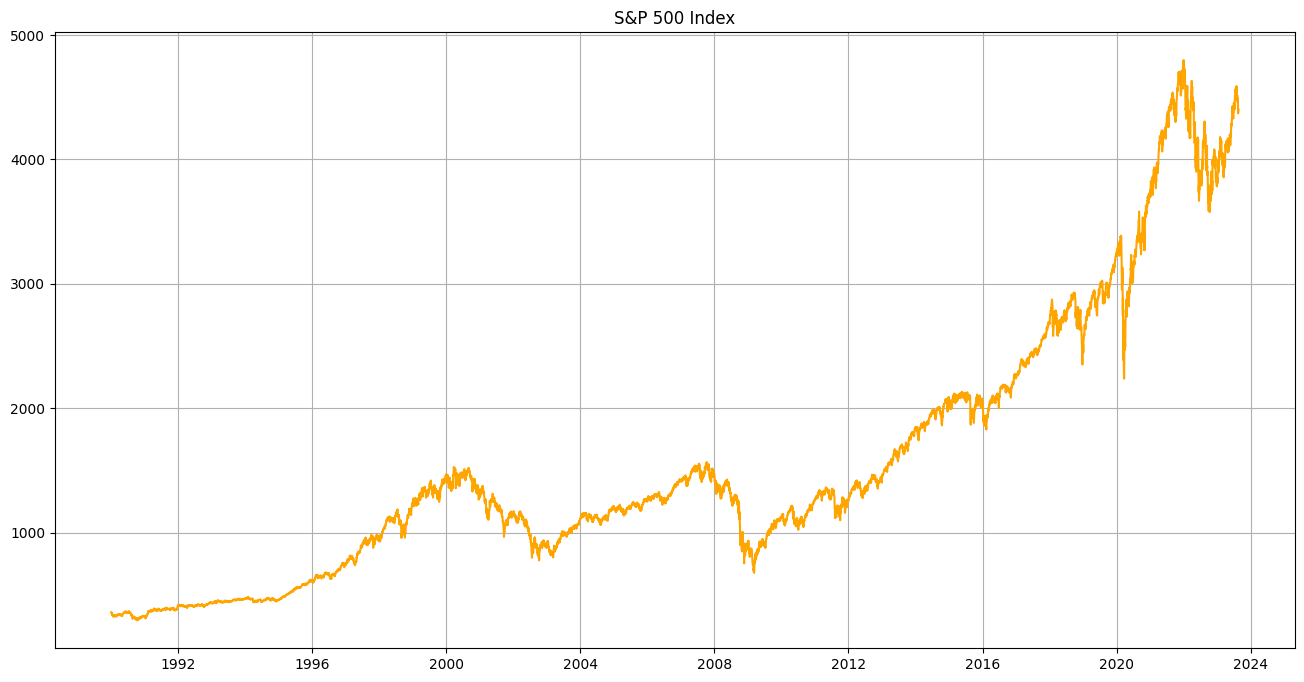

In [4]:
# Visualize S&P500 Index Price
plt.plot(df['^GSPC'], color='orange')
plt.title('S&P 500 Index')
plt.grid(True)

In [6]:
# Calculate daily returns
returns = np.log(df["^GSPC"]).diff().fillna(0)
returns

Date
1990-01-02    0.000000
1990-01-03   -0.002589
1990-01-04   -0.008650
1990-01-05   -0.009804
1990-01-08    0.004504
                ...   
2023-08-16   -0.007584
2023-08-17   -0.007743
2023-08-18   -0.000149
2023-08-21    0.006856
2023-08-22    0.000000
Name: ^GSPC, Length: 8475, dtype: float64

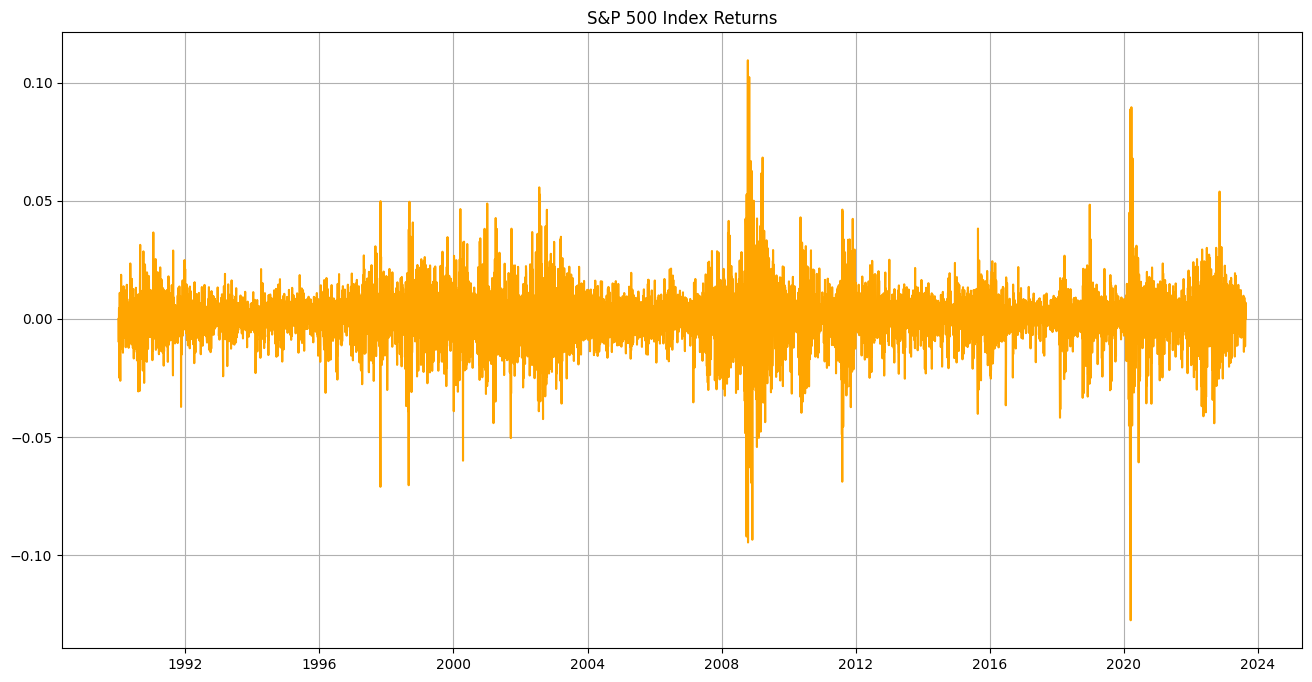

In [7]:
# Visualize S&P 500 Index daily returns
plt.plot(returns, color='orange')
plt.title('S&P 500 Index Returns')
plt.grid(True)

In [8]:
# GARCH(1, 1) function
def garch(omega, alpha, beta, ret):
    
    length = len(ret)
    
    var = []
    for i in range(length):
        if i == 0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha*ret[i-1]**2 + beta*var[i-1])
    
    return np.array(var)

In [9]:
garch(0.00000790570, 0.1, 0.8, returns)[:3]

array([7.90570000e-05, 7.11513000e-05, 6.54969739e-05])

In [10]:
# Log likelihood function
def likelihood(params, ret):
    
    length = len(ret)
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    
    variance = garch(omega, alpha, beta, ret)
    
    llh = []
    for i in range(length):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
        
    return -np.sum(np.array(llh))

In [11]:
likelihood((0.00000790570, 0.1, 0.8), returns)

-27513.911220283175

In [12]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = (0.00000790570, 0.1, 0.8)

In [14]:
res = minimize(likelihood, initial_values, args = returns, method='Nelder-Mead', options={'disp':False})
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -27696.642754236236
             x: [ 1.711e-06  9.970e-02  8.864e-01]
           nit: 66
          nfev: 121
 final_simplex: (array([[ 1.711e-06,  9.970e-02,  8.864e-01],
                       [ 1.711e-06,  9.974e-02,  8.864e-01],
                       [ 1.714e-06,  9.977e-02,  8.864e-01],
                       [ 1.713e-06,  9.974e-02,  8.864e-01]]), array([-2.770e+04, -2.770e+04, -2.770e+04, -2.770e+04]))

In [15]:
# GaARCH parameters 
dict(zip(param, np.around(res['x']*100, 4)))

{'omega': 0.0002, 'alpha': 9.97, 'beta': 88.6443}

In [16]:
# parameters
omega = res['x'][0]
alpha = res['x'][1]
beta = res['x'][2]

# variance
var = garch(omega, alpha, beta, returns)

# Annualized conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol

array([17.63746053, 16.73515439, 15.9454262 , ..., 12.02267102,
       11.5085536 , 11.55532804])

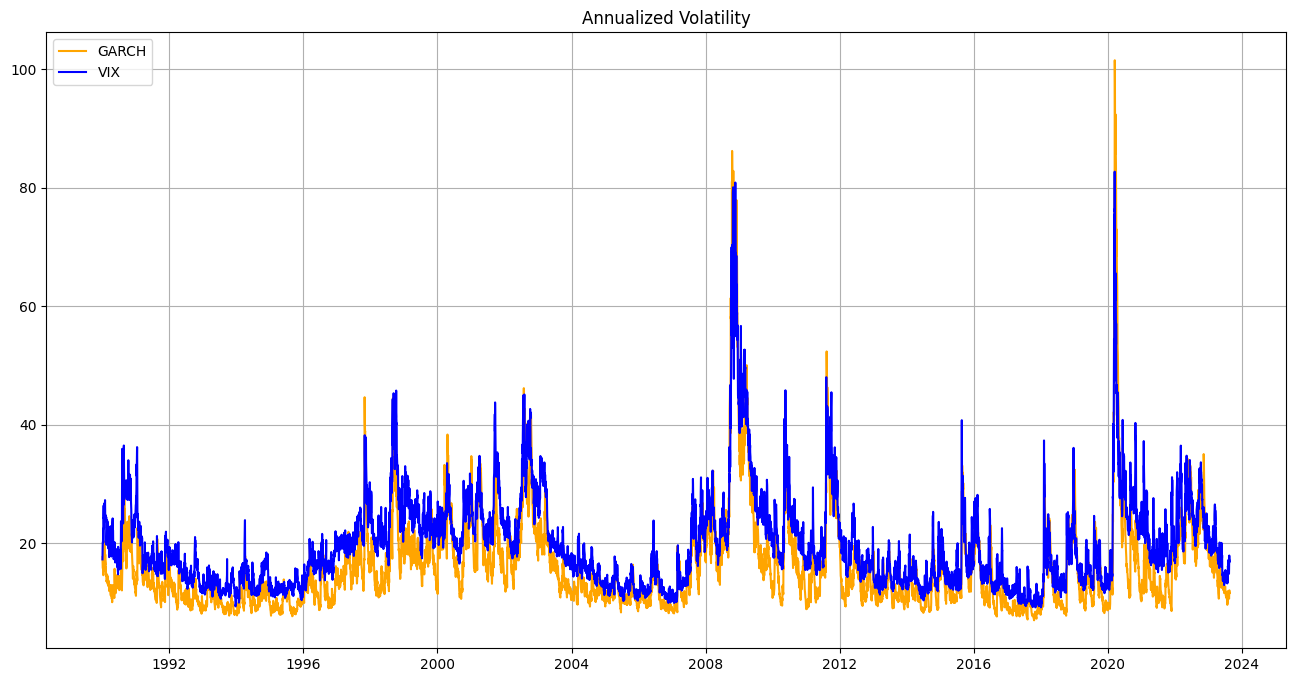

In [18]:
# Visualize GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.plot(returns.index, df['^VIX'], color='blue', label='VIX')
plt.legend(loc=2)
plt.grid(True)

In [19]:
# Calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)

fvar=[]
for i in range(1, 732):
    fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))
    
var = np.array(fvar)    

In [20]:
# Verify first 10 values
var[:10]

array([5.39626989e-05, 5.49255168e-05, 5.58749928e-05, 5.68113118e-05,
       5.77346561e-05, 5.86452055e-05, 5.95431373e-05, 6.04286263e-05,
       6.13018450e-05, 6.21629633e-05])

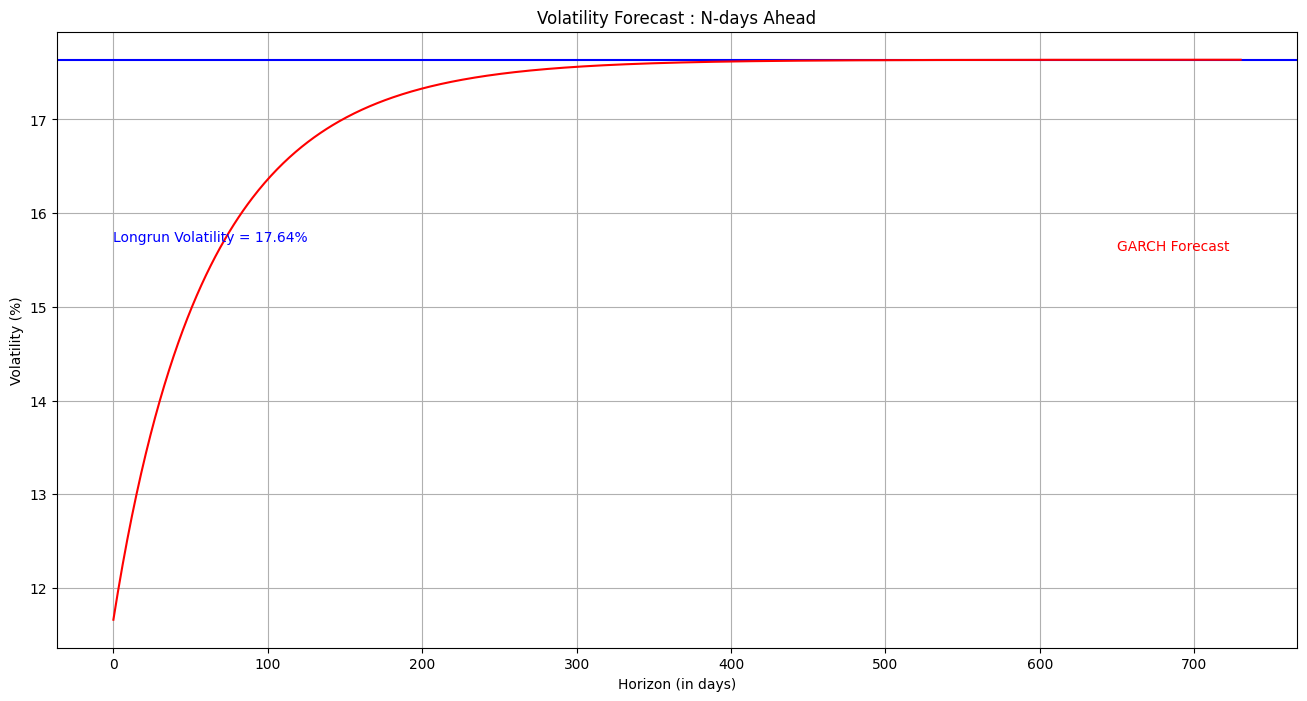

In [21]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='blue')
plt.plot(np.sqrt(var*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(650, 15.60), color='red')
plt.annotate('Longrun Volatility = ' + str(np.around(np.sqrt(longrun_variance*252)*100, 2)) + '%', xy=(0, 15.70), color='blue')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(True)

In [22]:
# Import ARCH library
from arch import arch_model

In [23]:
# Mean zero
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')
model = g1.fit()

# Model output
print(model)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -27680.42249118328
Optimization terminated successfully    (Exit mode 0)
            Current function value: -27680.422522328907
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                27680.4
Distribution:                  Normal   AIC:                          -55354.8
Method:            Maximum Likelihood   BIC:                          -55333.7
                                        No. Observations:                 8475
Date:                Tue, Aug 22 2023   Df Residuals:                     8475
Time:                        11:05:31   Df Model:                            0
        

In [24]:
# Model params
model.params

omega       0.000003
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

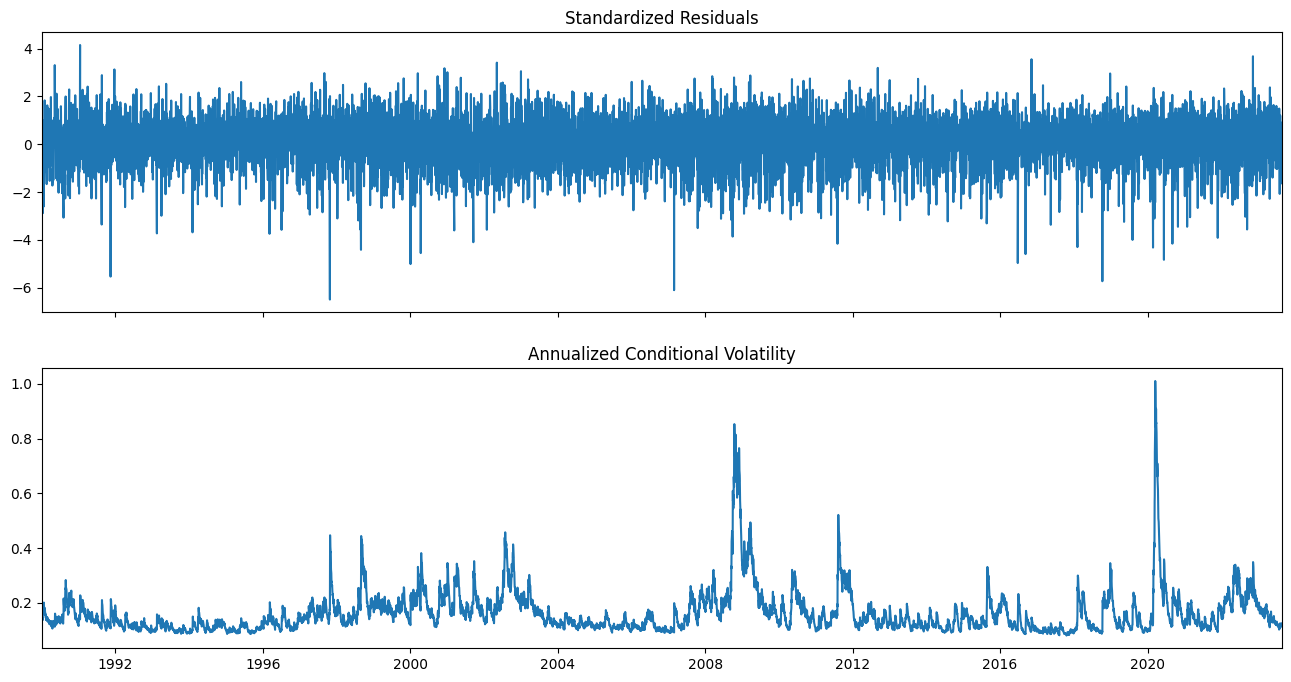

In [25]:
# Plot annualized vol
fig = model.plot(annualize='D')

In [26]:
model.conditional_volatility*np.sqrt(252)

Date
1990-01-02    0.153092
1990-01-03    0.145914
1990-01-04    0.139896
1990-01-05    0.140620
1990-01-08    0.143141
                ...   
2023-08-16    0.123085
2023-08-17    0.124288
2023-08-18    0.125581
2023-08-21    0.120601
2023-08-22    0.121036
Name: cond_vol, Length: 8475, dtype: float64

In [27]:
# Constante mean
g2 = arch_model(returns, vol='GARCH', mean='Constant', p=1, o=0, q=1, dist='Normal')

# Model output
model2 = g2.fit(disp='off')
print(model2)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                27528.3
Distribution:                  Normal   AIC:                          -55048.6
Method:            Maximum Likelihood   BIC:                          -55020.5
                                        No. Observations:                 8475
Date:                Tue, Aug 22 2023   Df Residuals:                     8474
Time:                        11:08:16   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.0547e-03  1.125e-04     -9.375  6.8

In [28]:
# Forecast for next 60 days
model_forecast = model.forecast(horizon=60)

In [29]:
# Subsume forecast values into a dataframe
forecast_df = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T * 252)*100)
forecast_df.columns = ['Cond_Vol']
forecast_df.head()

,Cond_Vol
h.01,11.643754
h.02,11.812088
h.03,11.974759
h.04,12.132062
h.05,12.284264


In [31]:
# Long run variance from model forecast
lrv = model.params[0]/(1-model.params[1]-model.params[2])

# Long run variance
np.sqrt(lrv*252)*100

18.248223329307677

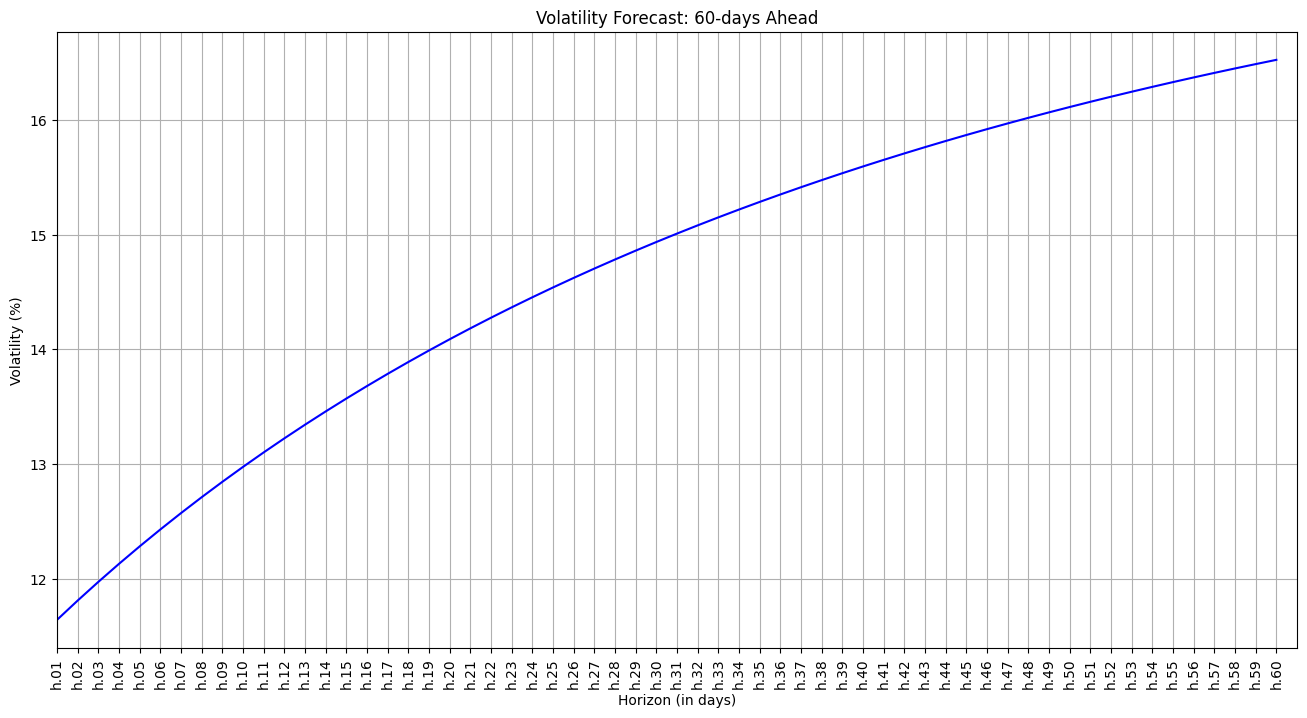

In [33]:
# Plot volatility forecast over a 60-day horizon
plt.plot(forecast_df, color='blue')
plt.xlim(0,60)
plt.xticks(rotation=90)
plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')
plt.title('Volatility Forecast: 60-days Ahead')
plt.grid(True)